# Hierarchical modeling

_Author: Christoph Rahmede_

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-1">Load the data</a></span></li><li><span><a href="#Relation-between-casual-rides-and-total-counts" data-toc-modified-id="Relation-between-casual-rides-and-total-counts-2">Relation between casual rides and total counts</a></span><ul class="toc-item"><li><span><a href="#Resolved-by-hour" data-toc-modified-id="Resolved-by-hour-2.1">Resolved by hour</a></span></li></ul></li><li><span><a href="#Beta-binomial-algebraically" data-toc-modified-id="Beta-binomial-algebraically-3">Beta-binomial algebraically</a></span></li><li><span><a href="#Beta-binomial-with-pymc3" data-toc-modified-id="Beta-binomial-with-pymc3-4">Beta-binomial with pymc3</a></span></li><li><span><a href="#Hierarchical-models" data-toc-modified-id="Hierarchical-models-5">Hierarchical models</a></span></li><li><span><a href="#More-hierarchies" data-toc-modified-id="More-hierarchies-6">More hierarchies</a></span></li><li><span><a href="#Resources" data-toc-modified-id="Resources-7">Resources</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
import pymc3 as pm
import arviz as az

## Load the data

In [3]:
df = pd.read_csv(
    '../../../dataset-collection/Bike-Sharing-Dataset/hour.csv')
df.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

## Relation between casual rides and total counts

In [4]:
df['casual_pct'] = df['casual']/df['cnt']

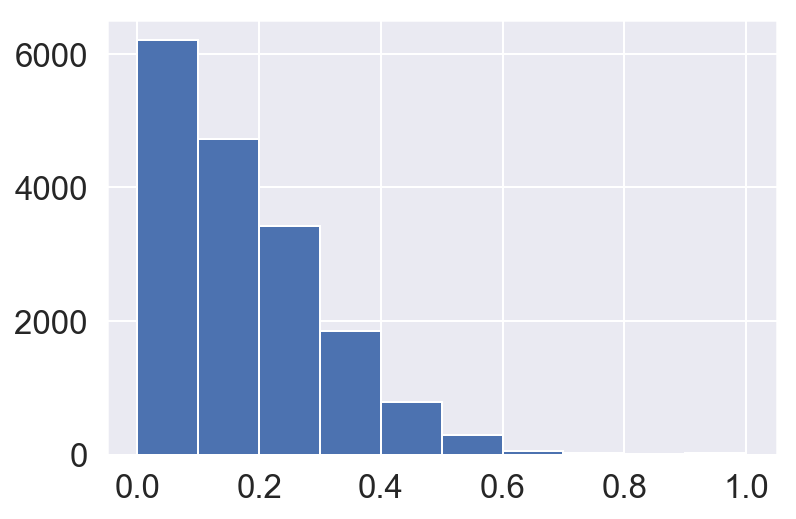

In [5]:
df['casual_pct'].hist();

In [6]:
df['casual_pct'].describe()

count    17379.000000
mean         0.172143
std          0.136557
min          0.000000
25%          0.063492
50%          0.146893
75%          0.253731
max          1.000000
Name: casual_pct, dtype: float64

### Resolved by hour

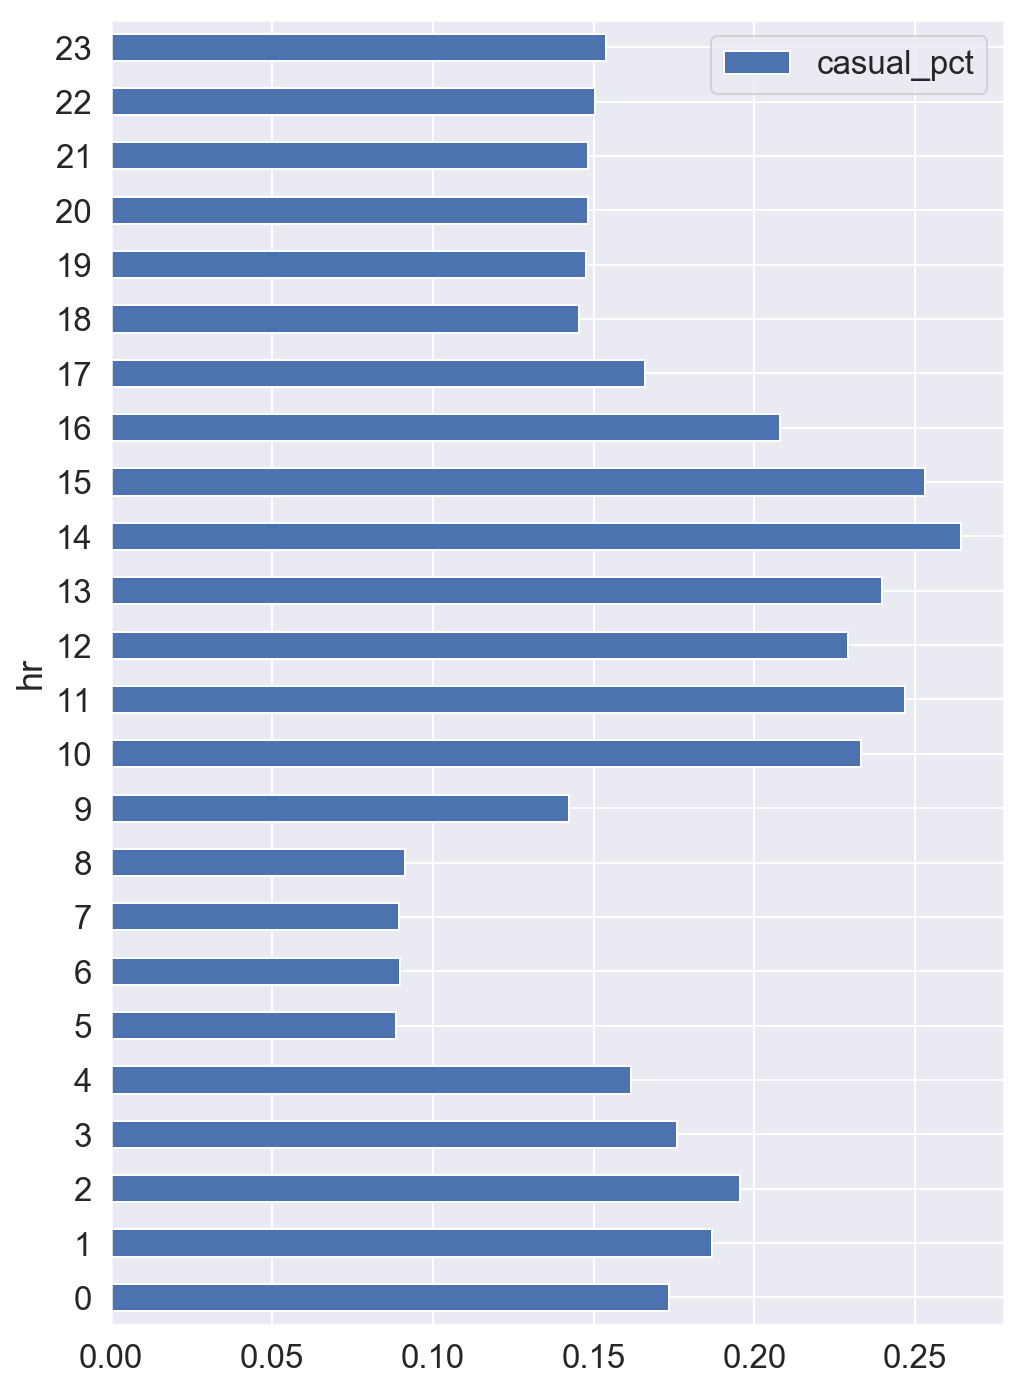

In [7]:
grouped = df.groupby('hr')[['casual_pct']]
grouped.mean().plot(kind='barh',figsize=(8,12));

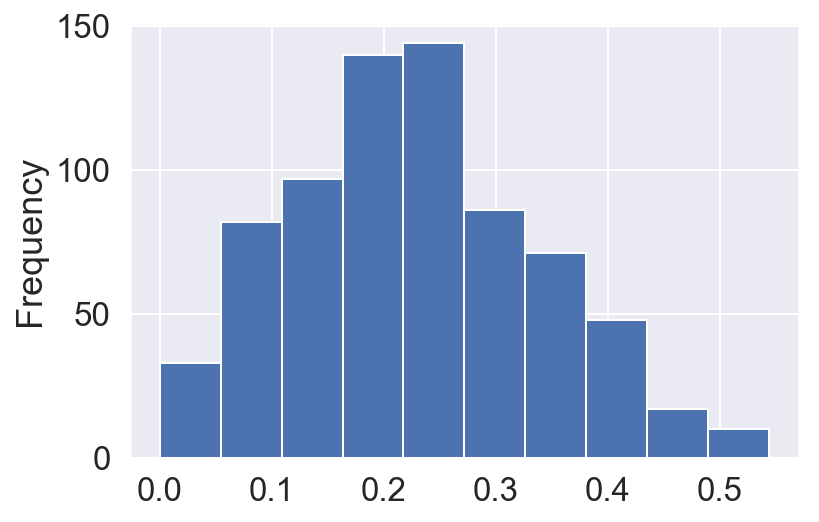

In [8]:
df[df.hr==12].casual_pct.plot(kind='hist');

## Beta-binomial algebraically

In [9]:
df[['casual','registered']].iloc[:3]

casual  registered
0       3          13
1       8          32
2       5          27

In [10]:
from scipy import stats

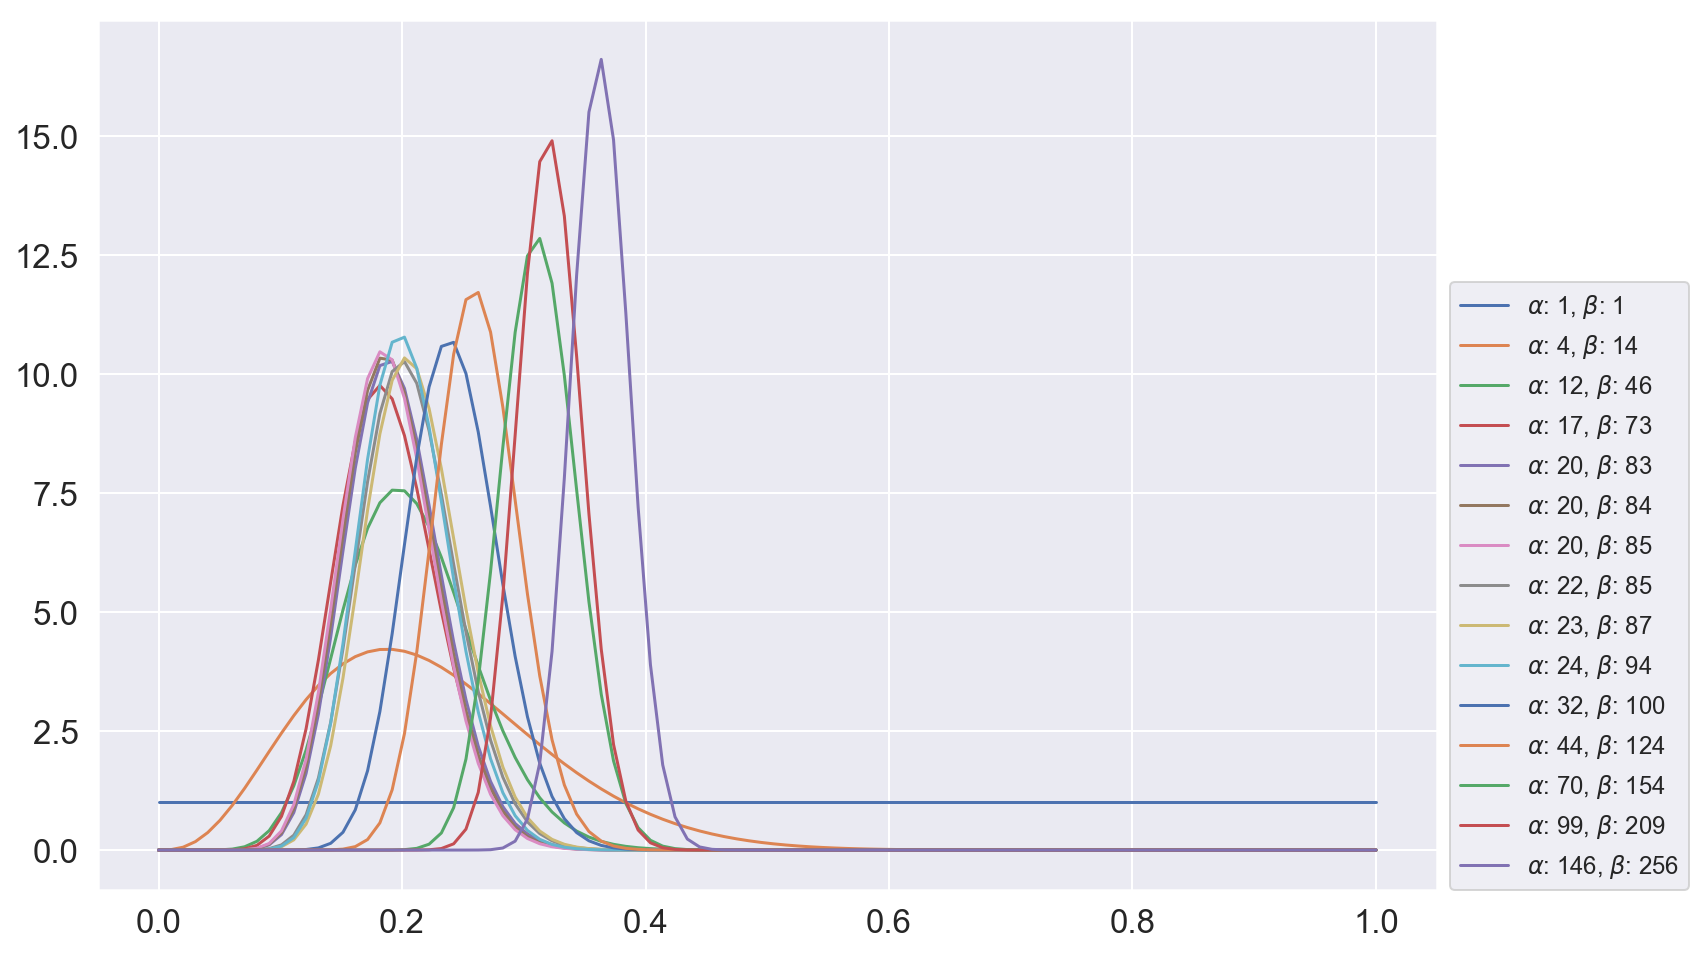

In [11]:
alpha = 1
beta = 1
xvals = np.linspace(0,1,100)

fig, ax = plt.subplots(figsize=(12,8))
for i in range(30):
    beta_dist = stats.beta(alpha,beta)
    yvals = beta_dist.pdf(xvals)
    if i < 15:
        ax.plot(xvals,yvals,label=r'$\alpha$: {}, $\beta$: {}'.format(alpha,beta))
    alpha += df.casual[i]
    beta += df.registered[i]
ax.legend(loc=[1.01,0],fontsize=12)
plt.show()

## Beta-binomial with pymc3

In [12]:
sample = df[:100][['casual','cnt']]

In [13]:
sample_ratio = sample.sum()[0]/sample.sum()[1]
sample_ratio

0.1379173290937997

In [14]:
alpha = 5
beta = 3
with pm.Model() as model:
    theta = pm.Beta('p',alpha,beta)
    likelihood = pm.Binomial('likelihood',n=sample.sum()[1],p=theta, observed=sample.sum()[0])     

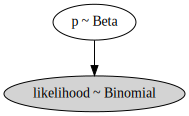

In [15]:
pm.model_to_graphviz(model)

In [16]:
with model:
    trace = pm.sample(draws=500, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 2305.88draws/s]


In [17]:
pm.summary(trace)

mean        sd  mc_error   hpd_2.5  hpd_97.5       n_eff      Rhat
p  0.138791  0.004877  0.000236  0.129619  0.147398  399.993099  1.000049

## Hierarchical models

Bayesian models allows us to construct models which involve many parameters. We want to obtain  the posterior from the prior and the likelihood. The latter describes the data conditioned on all the model parameters:

$$p(\theta,\omega|D) \propto p(D|\theta,\omega)p(\theta,\omega)
$$

Often we have the situation that the likelihood does not directly depend on all the model parameters, but only indirectly through its parameters:

$$
\begin{eqnarray*}
p(\theta,\omega|D) &\propto&p(D|\theta,\omega)p(\theta,\omega)\\
&=&p(D|\theta)p(\theta,\omega)\\
&=&p(D|\theta)p(\theta|\omega)p(\omega)
\end{eqnarray*}
$$

This situation often arises when we set prior distributions which have their own shape parameters, but also when we have data in categories and subcategories.

For example here we can resolve the casual and total counts per hour. Naturally we would believe that the proportions vary over the hours. But we could make the individual group statistics depend on the statistics of the larger group - this procedure is in particular useful if we have varying amounts of observations per group. Hierarchical models help to adjust to larger patterns without having to give up the finer structure.

We will see that depending on how much data we have, the priors which are informed about larger group means will have more or less influence on each group estimate.

In [18]:
grouped = df[:36].groupby('hr')[['casual','registered','cnt']]

In [19]:
grouped.sum()

casual  registered  cnt
hr                         
0        7          26   33
1        9          48   57
2        6          35   41
3        5          14   19
4        2           2    4
5        0           1    1
6        2           2    4
7        1           3    4
8        1          15   16
9        9          25   34
10      19          70   89
11      42          84  126
12      49         128  177
13      47          47   94
14      35          71  106
15      40          70  110
16      41          52   93
17      15          52   67
18       9          26   35
19       6          31   37
20      11          25   36
21       3          31   34
22      11          17   28
23      15          24   39

These are the proportions of casual to registered rides per group.

In [20]:
overall_ratio = (df.sum().casual/df.sum().registered)
overall_ratio

0.23198481513936292

In [21]:
group_ratios = (grouped.sum().casual/grouped.sum().registered)

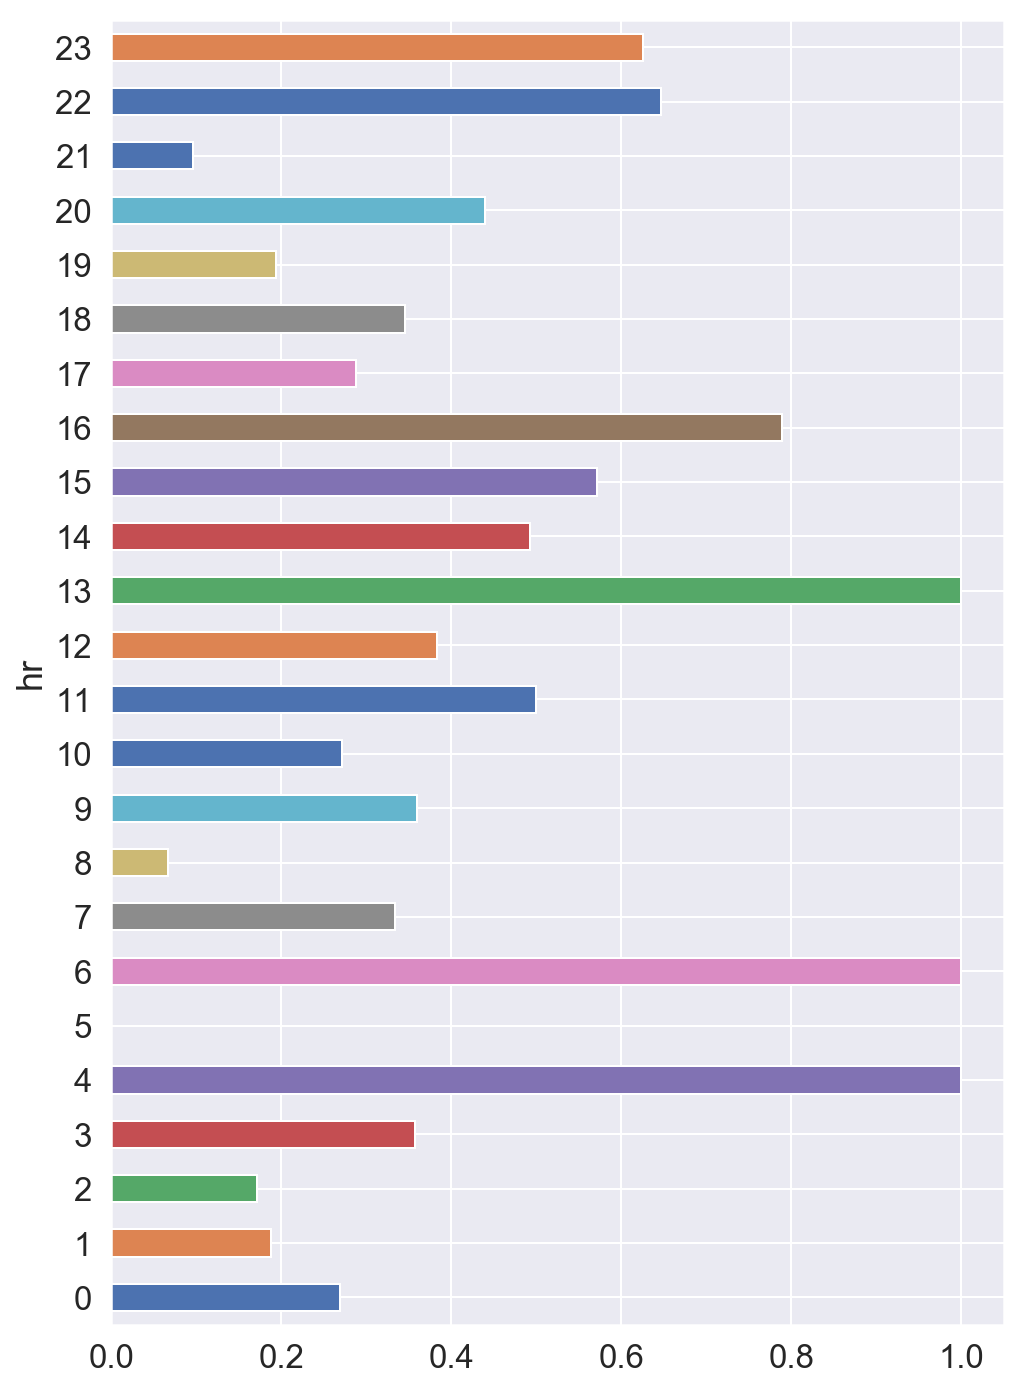

In [22]:
group_ratios.plot(kind='barh',figsize=(8,12))
plt.show()

In [23]:
casual = grouped.sum().casual
total = grouped.sum().cnt
registered = grouped.sum().registered

In [24]:
casual.values

array([ 7,  9,  6,  5,  2,  0,  2,  1,  1,  9, 19, 42, 49, 47, 35, 40, 41,
       15,  9,  6, 11,  3, 11, 15])

Our model will basically be a beta-binomial model for each of the groups. However we do not set the shape parameters of the beta-prior directly, but we will model them through their own distributions. To do so, we follow a setup for example suggested by [John Kruschke](#Kruschke).

We are not going to model the parameters of the prior ($\alpha$ and $\beta$, but rather parameters describing the mode and concentration (not the standard deviation, but related to the spread) of the beta distribution:

$$
\begin{eqnarray*}
\alpha &=& \omega(\kappa-2)+1 \\
\beta &=& (1-\omega)(\kappa-2)+1
\end{eqnarray*}
$$

Reverting the relationship we could also write
$$
\begin{eqnarray*}
\omega &=& \frac{\alpha-1}{\alpha+\beta-2} \\
\kappa &=& \alpha+\beta
\end{eqnarray*}
$$

The parameter $\omega$ we are going to model through another beta distribution whose shape parameters we are going to set by the total number of casual and registered rides irrespective of each group - in this way we inform about the group level higher in the hierarchy.

The parameter $\kappa$ we are modeling through a Gamma-distribution (which covers the whole real line), however certifying that each distribution covers only the appropriate range (in particular certifying $\kappa<2$ by shifting the Gamma-distribution). About this parameter we have less of a feeling about its appropriate value. Therefore we choose a very uninformed type of Gamma-prior.

We illustrate how this prior looks like through the following.

In [25]:
with pm.Model() as prior_dist:
    omega = pm.Beta('omega', alpha=df.casual.sum(), beta=df.registered.sum())
    kappa_minus2 = pm.Gamma('kappa_minus2', alpha=0.01, beta=0.01)
    trace_prior = pm.sample(5000,step=pm.Slice(),tune=1000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [kappa_minus2]
>Slice: [omega]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:05<00:00, 2292.78draws/s]


In [26]:
prior_dist

In [27]:
pm.summary(trace_prior)

mean        sd  mc_error        hpd_2.5  hpd_97.5  \
omega         0.188305  0.000216  0.000002   1.878923e-01  0.188733   
kappa_minus2  0.956158  8.617195  0.087457  1.274689e-321  0.433387   

                    n_eff      Rhat  
omega         9373.935561  0.999956  
kappa_minus2  9866.881573  0.999909

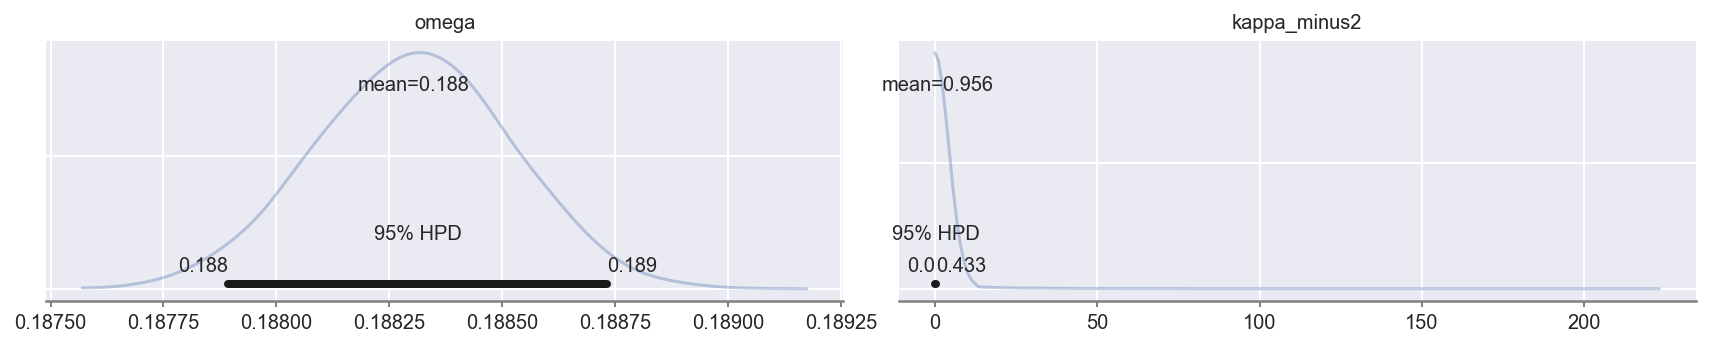

In [28]:
pm.plot_posterior(trace_prior,kde_plot=True);

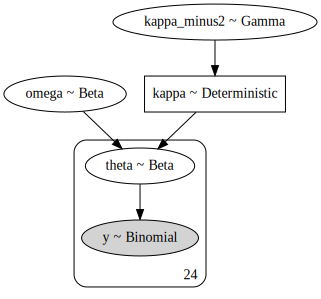

In [29]:
factor = 1

with pm.Model() as hierarchical_model:
    omega = pm.Beta('omega', 
                    alpha=factor*df.casual.sum(), 
                    beta=factor*df.registered.sum())
    kappa_minus2 = pm.Gamma('kappa_minus2', 
                            alpha=0.01, 
                            beta=0.01)
    kappa = pm.Deterministic('kappa', 
                             kappa_minus2 + 2)
    
    theta = pm.Beta('theta', 
                    alpha=omega*(kappa-2)+1, 
                    beta=(1-omega)*(kappa-2)+1, 
                    shape=24)
        
    y = pm.Binomial('y', 
                    n=total.values, 
                    p=theta, 
                    observed=casual.values
                    ) 
    
pm.model_to_graphviz(hierarchical_model)

In [30]:
with hierarchical_model:
    trace_h = pm.sample(1000,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, kappa_minus2, omega]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:11<00:00, 344.07draws/s]


In [31]:
pm.summary(trace_h)

mean        sd  mc_error   hpd_2.5   hpd_97.5        n_eff  \
omega          0.188301  0.000216  0.000003  0.187833   0.188691  6420.559693   
kappa_minus2  10.750655  4.485160  0.109832  3.453045  20.150824  1696.604181   
kappa         12.750655  4.485160  0.109832  5.453045  22.150824  1696.604181   
theta__0       0.218565  0.062389  0.000872  0.109157   0.349441  4702.981296   
theta__1       0.172930  0.045090  0.000626  0.086197   0.261836  4991.329733   
theta__2       0.166675  0.049413  0.000775  0.079877   0.264371  4742.271489   
theta__3       0.254494  0.076961  0.001137  0.110484   0.410649  5461.354845   
theta__4       0.306132  0.117294  0.001974  0.081116   0.526484  3704.351609   
theta__5       0.222818  0.112545  0.001743  0.030668   0.438364  3799.860669   
theta__6       0.307371  0.115373  0.001888  0.083410   0.519369  3417.858192   
theta__7       0.242043  0.102570  0.001792  0.066791   0.449737  3185.209230   
theta__8       0.136993  0.061068  0.000987  0.031919   0.254677  3939.204472   
theta__9       0.258497  0.064499  0.000964  0.137632   0.381970  4337.689914   
theta__10      0.216335  0.040579  0.000632  0.143466   0.296279  3714.584877   
theta__11      0.325011  0.041222  0.000597  0.244481   0.401875  5167.792062   
theta__12      0.274493  0.032099  0.000494  0.210205   0.334104  4233.787231   
theta__13      0.469035  0.050600  0.000771  0.362819   0.562310  4581.513118   
theta__14      0.319888  0.042108  0.000565  0.234787   0.397673  5015.884089   
theta__15      0.350981  0.043771  0.000716  0.266040   0.434067  4319.907784   
theta__16      0.415791  0.048930  0.000694  0.317482   0.507206  5176.029166   
theta__17      0.226346  0.047401  0.000681  0.133618   0.315979  5435.152240   
theta__18      0.253904  0.062549  0.001042  0.131099   0.370878  3729.145508   
theta__19      0.180936  0.058066  0.000938  0.072658   0.292067  5291.765057   
theta__20      0.290158  0.062440  0.000973  0.163053   0.406969  4655.995613   
theta__21      0.128578  0.049534  0.000803  0.033046   0.221529  4007.976687   
theta__22      0.346381  0.073275  0.001162  0.210907   0.490566  4466.927418   
theta__23      0.347720  0.066672  0.001020  0.226506   0.478268  4726.932744   

                  Rhat  
omega         1.001347  
kappa_minus2  0.999522  
kappa         0.999522  
theta__0      0.999997  
theta__1      0.999914  
theta__2      1.000614  
theta__3      0.999532  
theta__4      0.999507  
theta__5      1.000730  
theta__6      1.000643  
theta__7      1.003632  
theta__8      0.999976  
theta__9      1.000780  
theta__10     1.000613  
theta__11     0.999688  
theta__12     0.999636  
theta__13     0.999688  
theta__14     0.999559  
theta__15     0.999563  
theta__16     0.999635  
theta__17     0.999525  
theta__18     0.999644  
theta__19     0.999508  
theta__20     0.999671  
theta__21     1.000298  
theta__22     0.999585  
theta__23     0.999620

In [32]:
group_model = pd.DataFrame([group_ratios.values,trace_h['theta'].mean(axis=0)],index=['group','model'])
group_model

0        1         2         3         4         5         6   \
group  0.269231  0.18750  0.171429  0.357143  1.000000  0.000000  1.000000   
model  0.218565  0.17293  0.166675  0.254494  0.306132  0.222818  0.307371   

             7         8         9    ...           14        15        16  \
group  0.333333  0.066667  0.360000   ...     0.492958  0.571429  0.788462   
model  0.242043  0.136993  0.258497   ...     0.319888  0.350981  0.415791   

             17        18        19        20        21        22       23  
group  0.288462  0.346154  0.193548  0.440000  0.096774  0.647059  0.62500  
model  0.226346  0.253904  0.180936  0.290158  0.128578  0.346381  0.34772  

[2 rows x 24 columns]

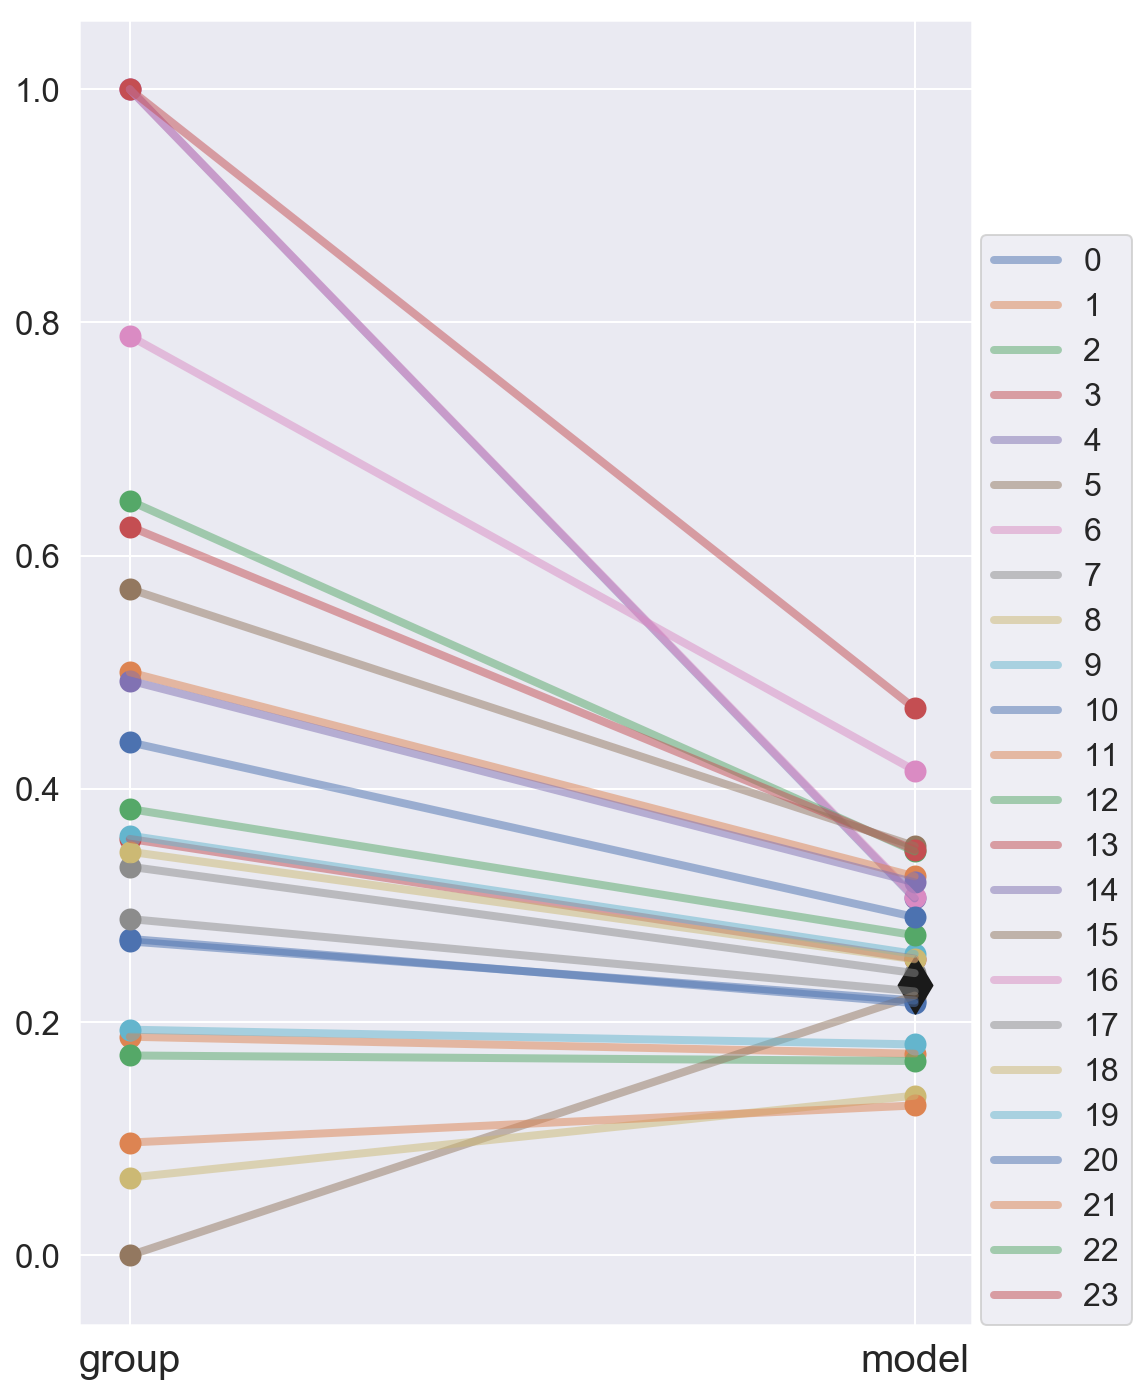

In [33]:
fig, ax = plt.subplots(figsize=(8,12))
group_model.plot(lw=4, ax=ax, alpha=0.5)
for col in group_model.columns:
    ax.scatter([0,1],group_model[col].values,s=100)
ax.scatter([1],[overall_ratio],marker='d', s=400, color='k')
ax.legend(loc=[1.01,0],fontsize=16)
plt.xticks([0,1],['group','model'],fontsize=20)
plt.show()

Differences between groups and model:

In [34]:
np.around((grouped.sum().casual/grouped.sum().cnt).values-trace_h['theta'].mean(axis=0),5)

array([-0.00644, -0.01504, -0.02033,  0.00866,  0.19387, -0.22282,
        0.19263,  0.00796, -0.07449,  0.00621, -0.00285,  0.00832,
        0.00234,  0.03097,  0.0103 ,  0.01266,  0.02507, -0.00247,
        0.00324, -0.01877,  0.0154 , -0.04034,  0.04648,  0.0369 ])

In [35]:
rope_boundaries = overall_ratio+0.01*np.array([-1,1])

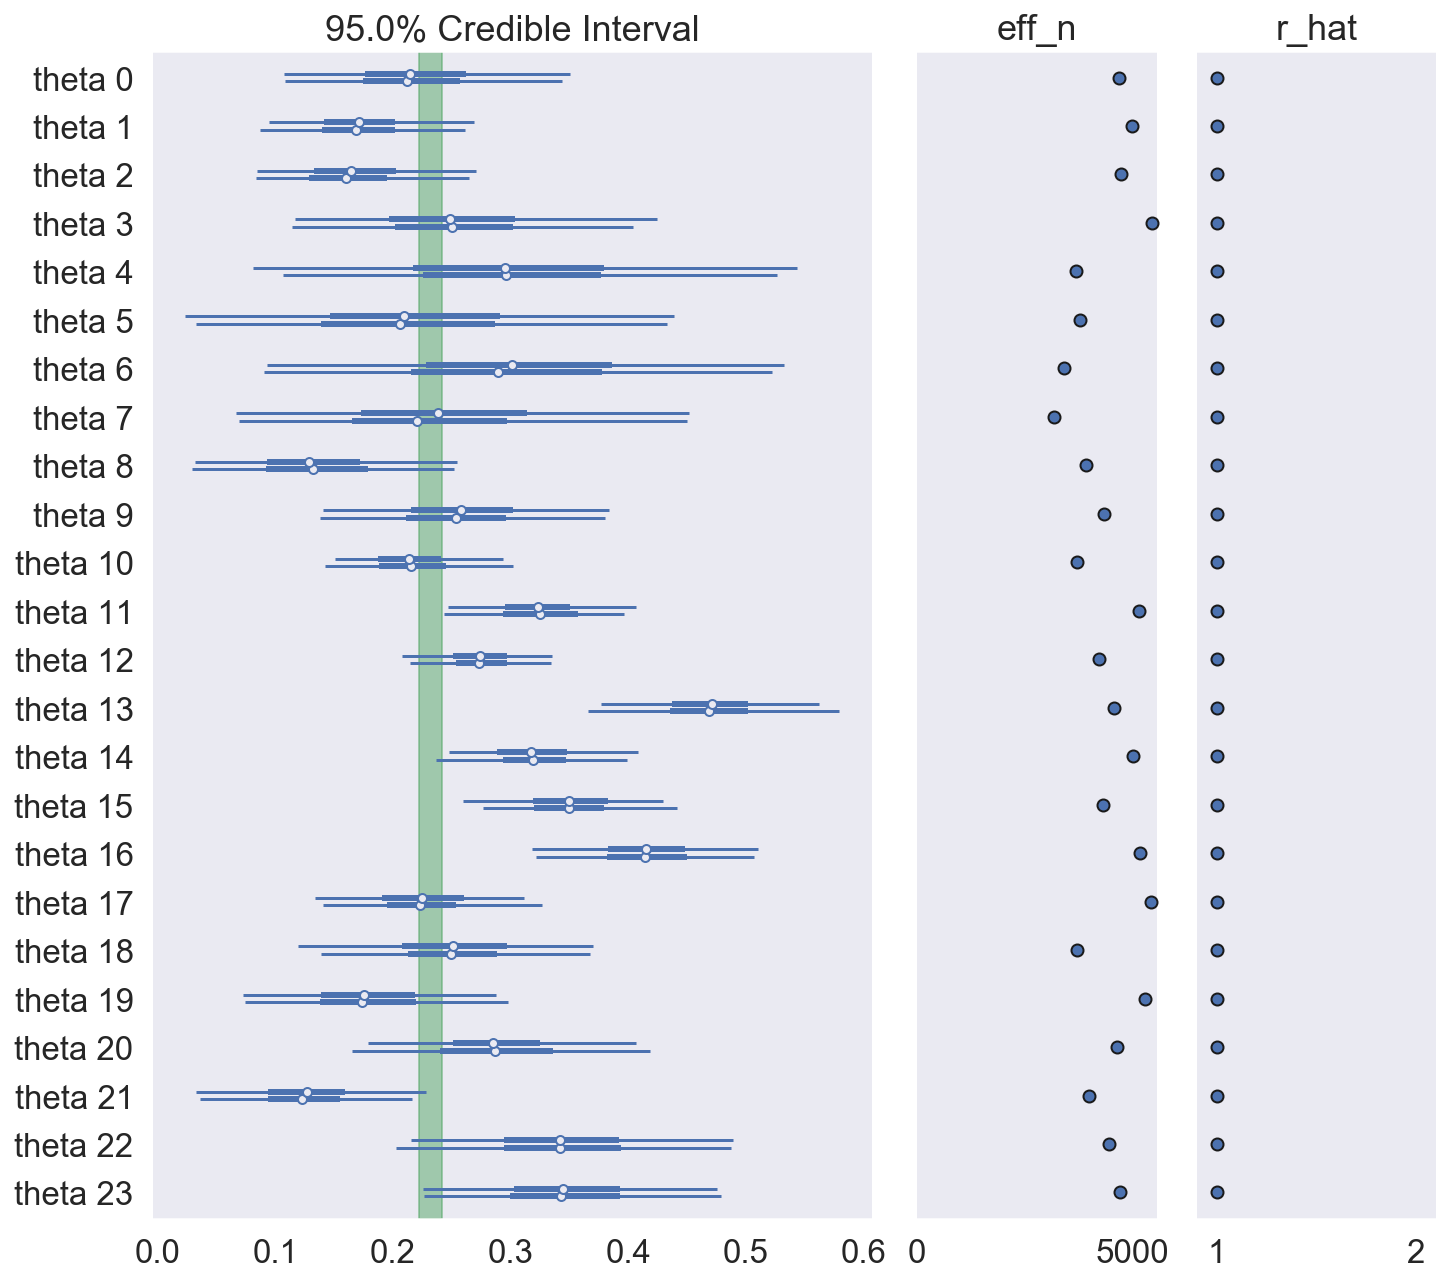

In [36]:
az.plot_forest(trace_h, var_names=['theta'], rope=rope_boundaries, eff_n=True, r_hat=True, credible_interval=0.95)
plt.show()

## More hierarchies


- Group additionally by working day
- Take workingday/weekend as an additional hierarchy level
- Take at least as many data points as required to have entries for all 48 lowest hierarchy levels
- Add an intermediate level for theta parameters informed about the overall theta and feeding down to the individual entries
- No need to add an additional level for the kappa parameter 

In [37]:
df.workingday.value_counts(normalize=True)

1    0.682721
0    0.317279
Name: workingday, dtype: float64

In [38]:
weekday_ratio = (df[df.workingday==1].sum().casual/df[df.workingday==1].sum().registered)
weekday_ratio

0.15247156412995663

In [39]:
weekend_ratio = (df[df.workingday==0].sum().casual/df[df.workingday==0].sum().registered)
weekend_ratio

0.4633721364022723

In [40]:
i = 0
j = 5000
(df[:j][df[:j].workingday==i].sum().casual/df[:j][df[:j].workingday==i].sum().registered)

0.5446984690610629

In [41]:
grouped_w = df[:1000].groupby(['workingday','hr'])[['casual','registered','cnt']]
grouped_w.sum()

casual  registered   cnt
workingday hr                          
0          0       36         374   410
           1       36         292   328
           2       24         207   231
           3       32          97   129
           4        4          34    38
           5        1          27    28
           6        6          27    33
           7       12          77    89
           8       17         265   282
           9       59         421   480
           10     112         824   936
           11     220         921  1141
           12     314        1176  1490
           13     325        1196  1521
           14     308        1222  1530
           15     355        1307  1662
           16     310        1221  1531
           17     206        1067  1273
           18     117         873   990
           19      88         674   762
           20      68         525   593
           21      64         483   547
           22      55         390   445
           23      50         350   400
1          0       38         255   293
           1       12         120   132
           2        9          54    63
           3        2          20    22
           4        3          28    31
           5        2         134   136
           6       15         774   789
           7       52        2198  2250
           8      110        4996  5106
           9      113        3079  3192
           10     104        1213  1317
           11     147        1206  1353
           12     168        1625  1793
           13     188        1667  1855
           14     158        1512  1670
           15     181        1509  1690
           16     183        2214  2397
           17     189        4707  4896
           18     105        4188  4293
           19      99        2800  2899
           20      72        1991  2063
           21      53        1396  1449
           22      48        1015  1063
           23      51         632   683

In [42]:
group_ratios_w = (grouped_w.sum().casual/grouped_w.sum().registered)

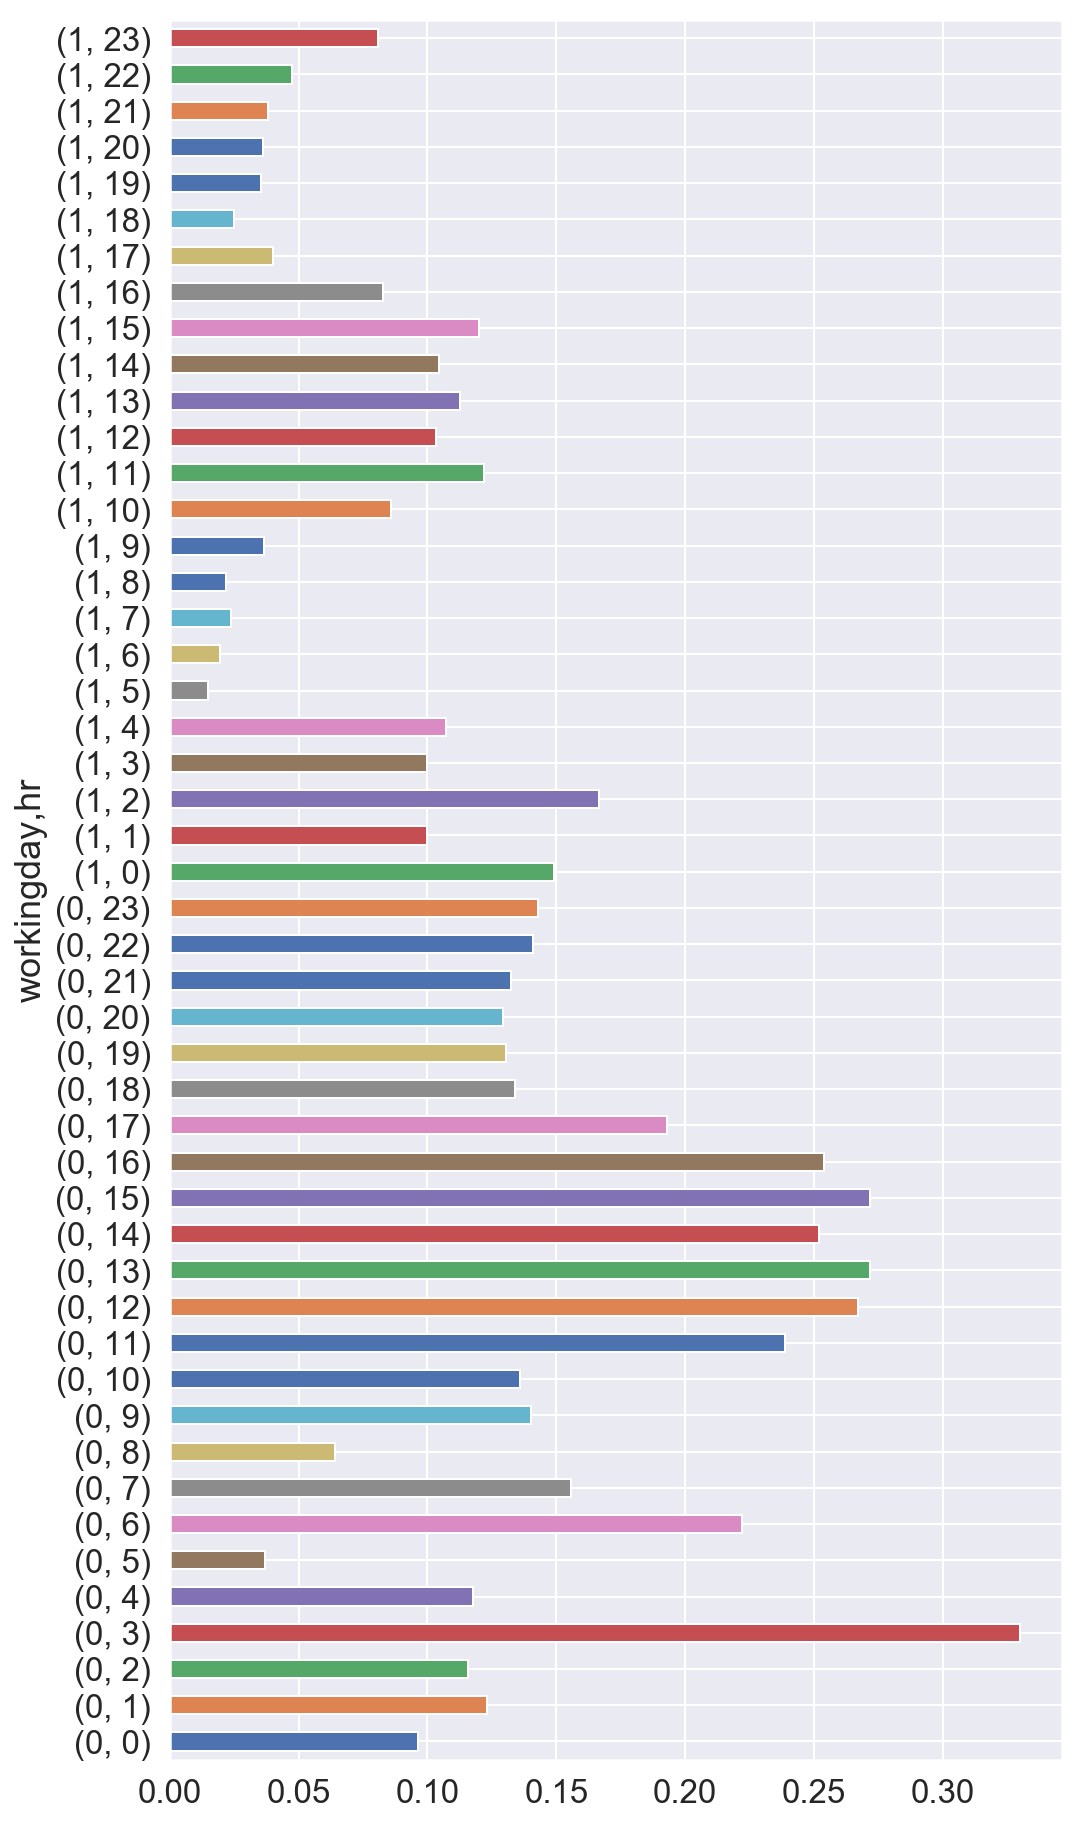

In [43]:
group_ratios_w.plot(kind='barh',figsize=(8,16))
plt.show()

In [44]:
casual_w = grouped_w.sum().casual
total_w = grouped_w.sum().cnt
registered_w = grouped_w.sum().registered

In [45]:
casual_w.values

array([ 36,  36,  24,  32,   4,   1,   6,  12,  17,  59, 112, 220, 314,
       325, 308, 355, 310, 206, 117,  88,  68,  64,  55,  50,  38,  12,
         9,   2,   3,   2,  15,  52, 110, 113, 104, 147, 168, 188, 158,
       181, 183, 189, 105,  99,  72,  53,  48,  51])

In [46]:
total_w.shape

(48,)

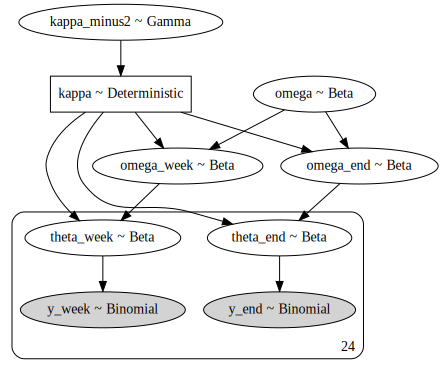

In [47]:
factor = 1

with pm.Model() as hierarchical_weekday:
    
    omega = pm.Beta('omega', 
                    alpha=factor*df.casual.sum(), 
                    beta=factor*df.registered.sum())
    kappa_minus2 = pm.Gamma('kappa_minus2', 
                            alpha=0.01, 
                            beta=0.01)
    kappa = pm.Deterministic('kappa', 
                             kappa_minus2 + 2)
    
    
    omega_end = pm.Beta('omega_end', 
                    alpha=omega*(kappa-2)+1, 
                    beta=(1-omega)*(kappa-2)+1)
    
    
    omega_week = pm.Beta('omega_week', 
                    alpha=omega*(kappa-2)+1, 
                    beta=(1-omega)*(kappa-2)+1)
    
    
    theta_end = pm.Beta('theta_end', 
                    alpha=omega_end*(kappa-2)+1, 
                    beta=(1-omega_end)*(kappa-2)+1, 
                    shape=24)
    
    theta_week = pm.Beta('theta_week', 
                    alpha=omega_week*(kappa-2)+1, 
                    beta=(1-omega_week)*(kappa-2)+1, 
                    shape=24)
        
    y_end = pm.Binomial('y_end', 
                    n=total_w[24:].values, 
                    p=theta_end, 
                    observed=casual_w[24:].values
                    ) 
    y_week = pm.Binomial('y_week', 
                    n=total_w[:24].values, 
                    p=theta_week, 
                    observed=casual_w[:24].values
                    ) 
    
pm.model_to_graphviz(hierarchical_weekday)

In [48]:
hierarchical_weekday

In [49]:
with hierarchical_weekday:
    trace_w = pm.sample(1000,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_week, theta_end, omega_week, omega_end, kappa_minus2, omega]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:14<00:00, 273.27draws/s]


In [50]:
pm.summary(trace_w)

mean        sd  mc_error    hpd_2.5   hpd_97.5  \
omega            0.188305  0.000211  0.000004   0.187925   0.188757   
kappa_minus2    37.442196  8.684258  0.179866  20.605928  54.445629   
kappa           39.442196  8.684258  0.179866  22.605928  56.445629   
omega_end        0.050134  0.008266  0.000143   0.033661   0.066256   
omega_week       0.131989  0.013692  0.000282   0.105606   0.159980   
theta_end__0     0.123060  0.017423  0.000281   0.090858   0.158848   
theta_end__1     0.087106  0.023128  0.000372   0.045990   0.131290   
theta_end__2     0.115951  0.032707  0.000511   0.055184   0.179279   
theta_end__3     0.079666  0.034632  0.000539   0.016868   0.144477   
theta_end__4     0.083766  0.034466  0.000507   0.024751   0.153052   
theta_end__5     0.028131  0.012752  0.000206   0.005285   0.052340   
theta_end__6     0.021744  0.005176  0.000084   0.012676   0.033196   
theta_end__7     0.024093  0.003120  0.000054   0.018292   0.030624   
theta_end__8     0.021892  0.002021  0.000027   0.018206   0.025790   
theta_end__9     0.035785  0.003201  0.000053   0.029280   0.041792   
theta_end__10    0.078785  0.007286  0.000117   0.064594   0.092550   
theta_end__11    0.107667  0.008282  0.000137   0.092969   0.124789   
theta_end__12    0.092970  0.006443  0.000097   0.080703   0.105544   
theta_end__13    0.100839  0.007156  0.000117   0.086807   0.114508   
theta_end__14    0.093997  0.007087  0.000105   0.080295   0.108153   
theta_end__15    0.106254  0.007695  0.000121   0.091994   0.122395   
theta_end__16    0.076370  0.005369  0.000099   0.064957   0.086188   
theta_end__17    0.038927  0.002729  0.000052   0.033504   0.044214   
theta_end__18    0.024848  0.002352  0.000038   0.020448   0.029590   
theta_end__19    0.034622  0.003346  0.000063   0.028134   0.040908   
theta_end__20    0.035528  0.004073  0.000067   0.027662   0.043339   
theta_end__21    0.037570  0.005045  0.000083   0.028597   0.047822   
theta_end__22    0.046206  0.006273  0.000090   0.033801   0.058464   
theta_end__23    0.074672  0.009668  0.000156   0.056817   0.093954   
theta_week__0    0.093707  0.013722  0.000236   0.067845   0.120412   
theta_week__1    0.114403  0.016345  0.000261   0.082273   0.145518   
theta_week__2    0.110864  0.019064  0.000310   0.073452   0.147025   
theta_week__3    0.226049  0.033124  0.000462   0.155554   0.288298   
theta_week__4    0.127293  0.038313  0.000676   0.057363   0.202134   
theta_week__5    0.102101  0.037336  0.000591   0.032979   0.175911   
theta_week__6    0.165292  0.043295  0.000623   0.086597   0.252331   
theta_week__7    0.139771  0.030599  0.000535   0.088125   0.202633   
theta_week__8    0.071982  0.014454  0.000256   0.045168   0.100139   
theta_week__9    0.125175  0.014503  0.000243   0.097809   0.154990   
theta_week__10   0.120977  0.010198  0.000162   0.101783   0.140522   
theta_week__11   0.191451  0.011337  0.000214   0.169311   0.212977   
theta_week__12   0.209316  0.010615  0.000174   0.187511   0.228795   
theta_week__13   0.212066  0.010296  0.000182   0.192757   0.232527   
theta_week__14   0.200024  0.009861  0.000155   0.180507   0.218802   
theta_week__15   0.212321  0.009866  0.000142   0.192552   0.230873   
theta_week__16   0.201091  0.010278  0.000148   0.179486   0.220506   
theta_week__17   0.161467  0.009848  0.000152   0.142030   0.181281   
theta_week__18   0.119487  0.009883  0.000146   0.101507   0.138752   
theta_week__19   0.117130  0.011484  0.000186   0.094879   0.139737   
theta_week__20   0.116640  0.012327  0.000218   0.092942   0.141087   
theta_week__21   0.119285  0.013354  0.000239   0.094097   0.146185   
theta_week__22   0.125981  0.014570  0.000228   0.097200   0.152177   
theta_week__23   0.127469  0.015609  0.000208   0.099227   0.157485   

                      n_eff      Rhat  
omega           2821.090368  0.999790  
kappa_minus2    2211.531593  0.999581  
kappa           2211.531593  0.999581  
omega_end       2912.24621

In [51]:
theta_means = np.concatenate([trace_w['theta_end'].mean(axis=0),trace_w['theta_week'].mean(axis=0)])

In [52]:
group_model_w = pd.DataFrame([group_ratios_w.values,theta_means],index=['group','model'])
group_model_w

0         1         2         3         4         5         6   \
group  0.096257  0.123288  0.115942  0.329897  0.117647  0.037037  0.222222   
model  0.123060  0.087106  0.115951  0.079666  0.083766  0.028131  0.021744   

             7         8         9     ...           38        39        40  \
group  0.155844  0.064151  0.140143    ...     0.104497  0.119947  0.082656   
model  0.024093  0.021892  0.035785    ...     0.200024  0.212321  0.201091   

             41        42        43        44        45        46        47  
group  0.040153  0.025072  0.035357  0.036163  0.037966  0.047291  0.080696  
model  0.161467  0.119487  0.117130  0.116640  0.119285  0.125981  0.127469  

[2 rows x 48 columns]

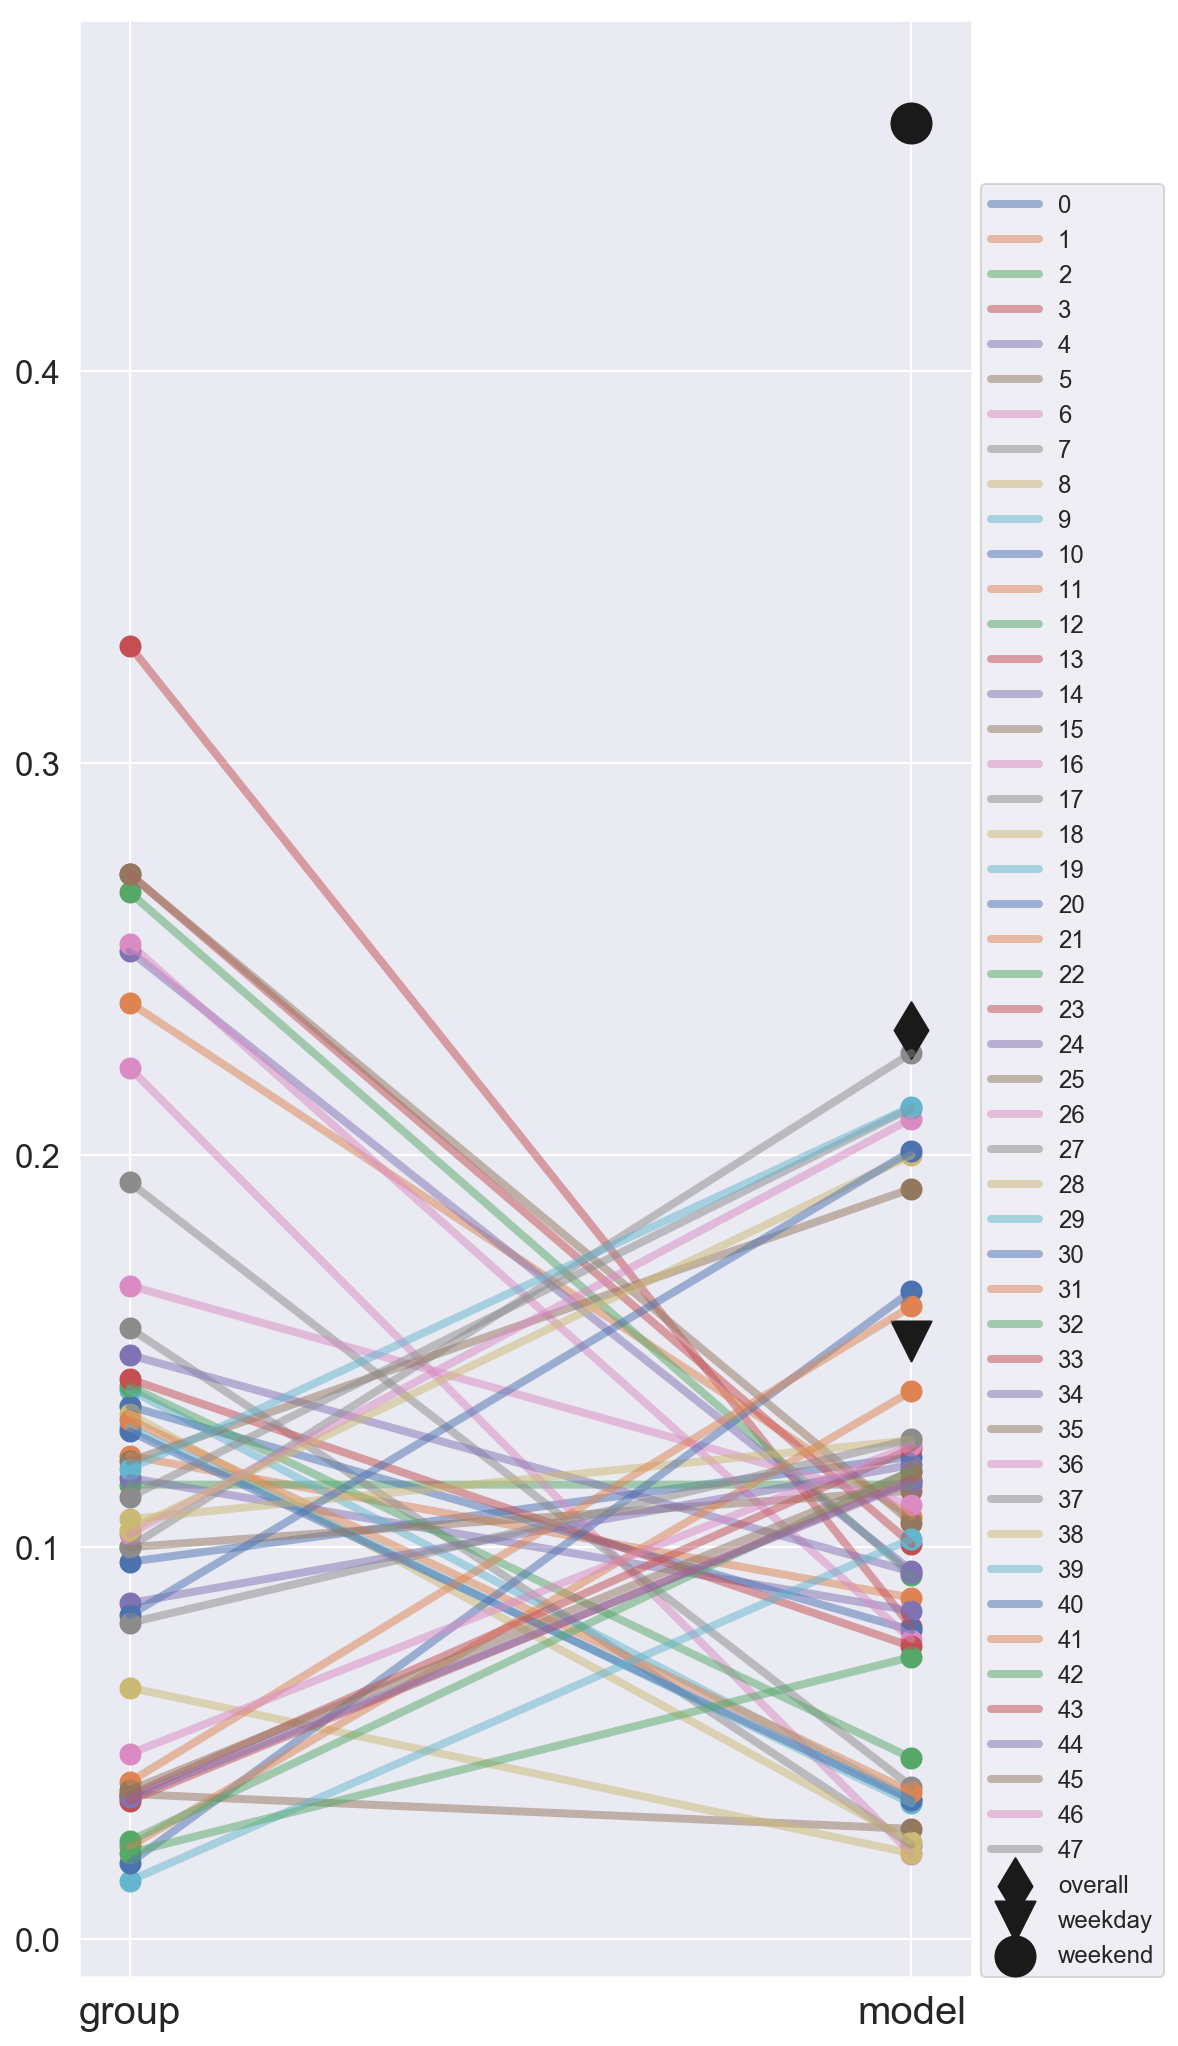

In [53]:
fig, ax = plt.subplots(figsize=(8,18))
group_model_w.plot(lw=4, ax=ax, alpha=0.5)
for col in group_model_w.columns:
    ax.scatter([0,1],group_model_w[col].values,s=100)
ax.scatter([1],[overall_ratio],marker='d', s=400, color='k',label='overall')
ax.scatter([1],[weekday_ratio],marker='v', s=400, color='k',label='weekday')
ax.scatter([1],[weekend_ratio],marker='o', s=400, color='k',label='weekend')
ax.legend(loc=[1.01,0],fontsize=12)
plt.xticks([0,1],['group','model'],fontsize=20)
plt.show()

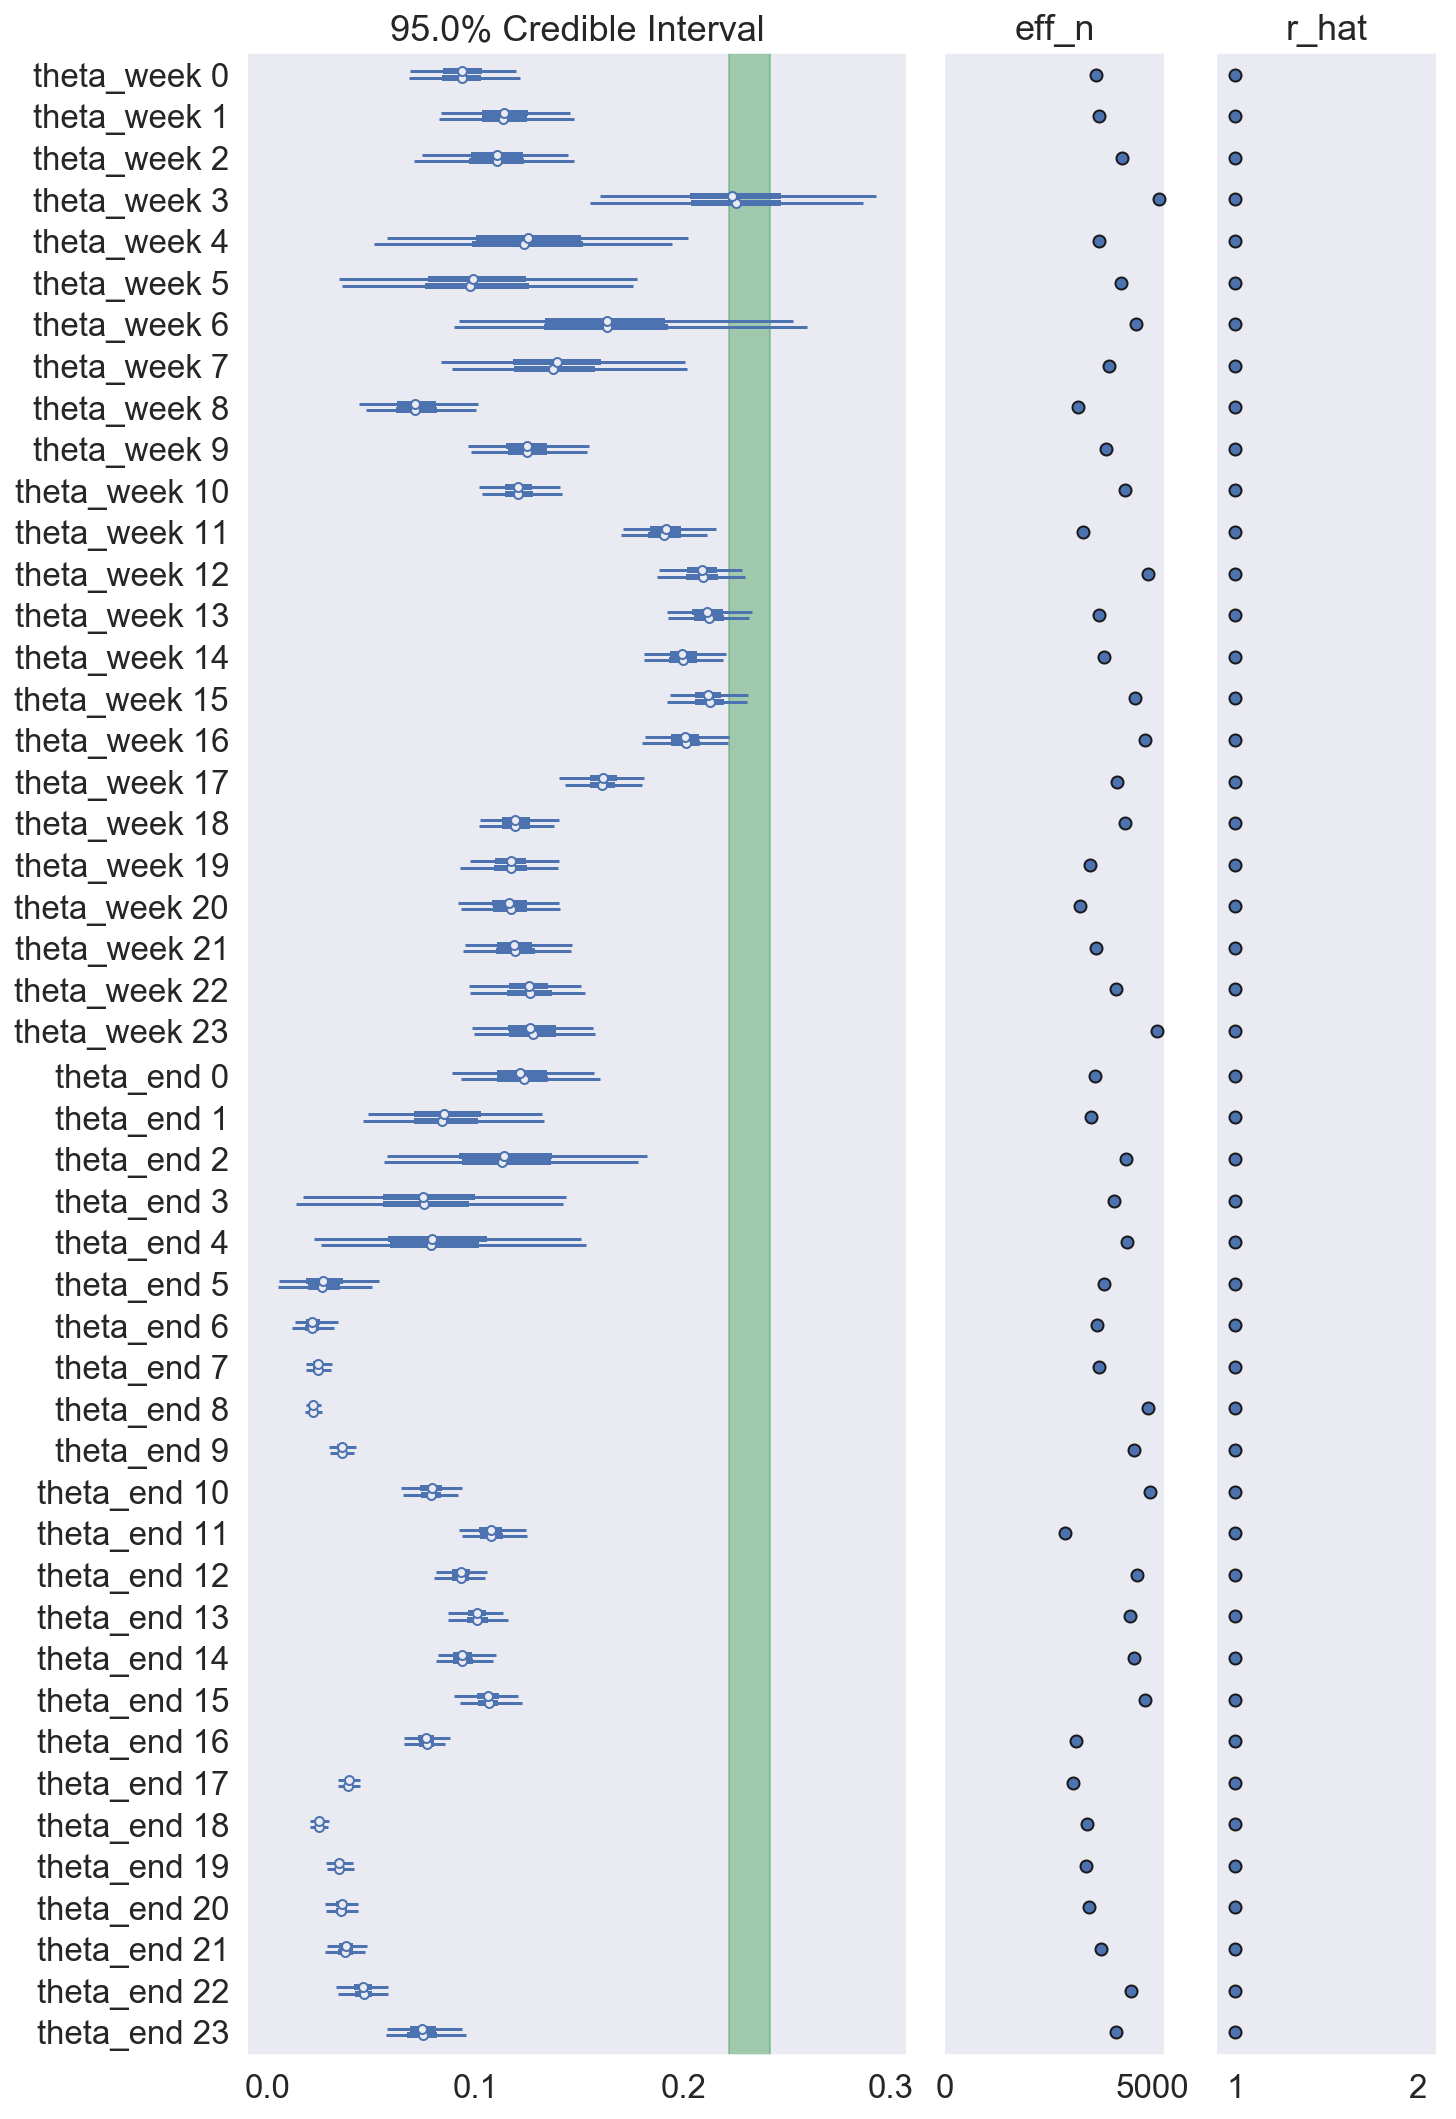

In [54]:
az.plot_forest(trace_w, var_names=['theta_week','theta_end'], rope=rope_boundaries, eff_n=True, r_hat=True, credible_interval=0.95)
plt.show()

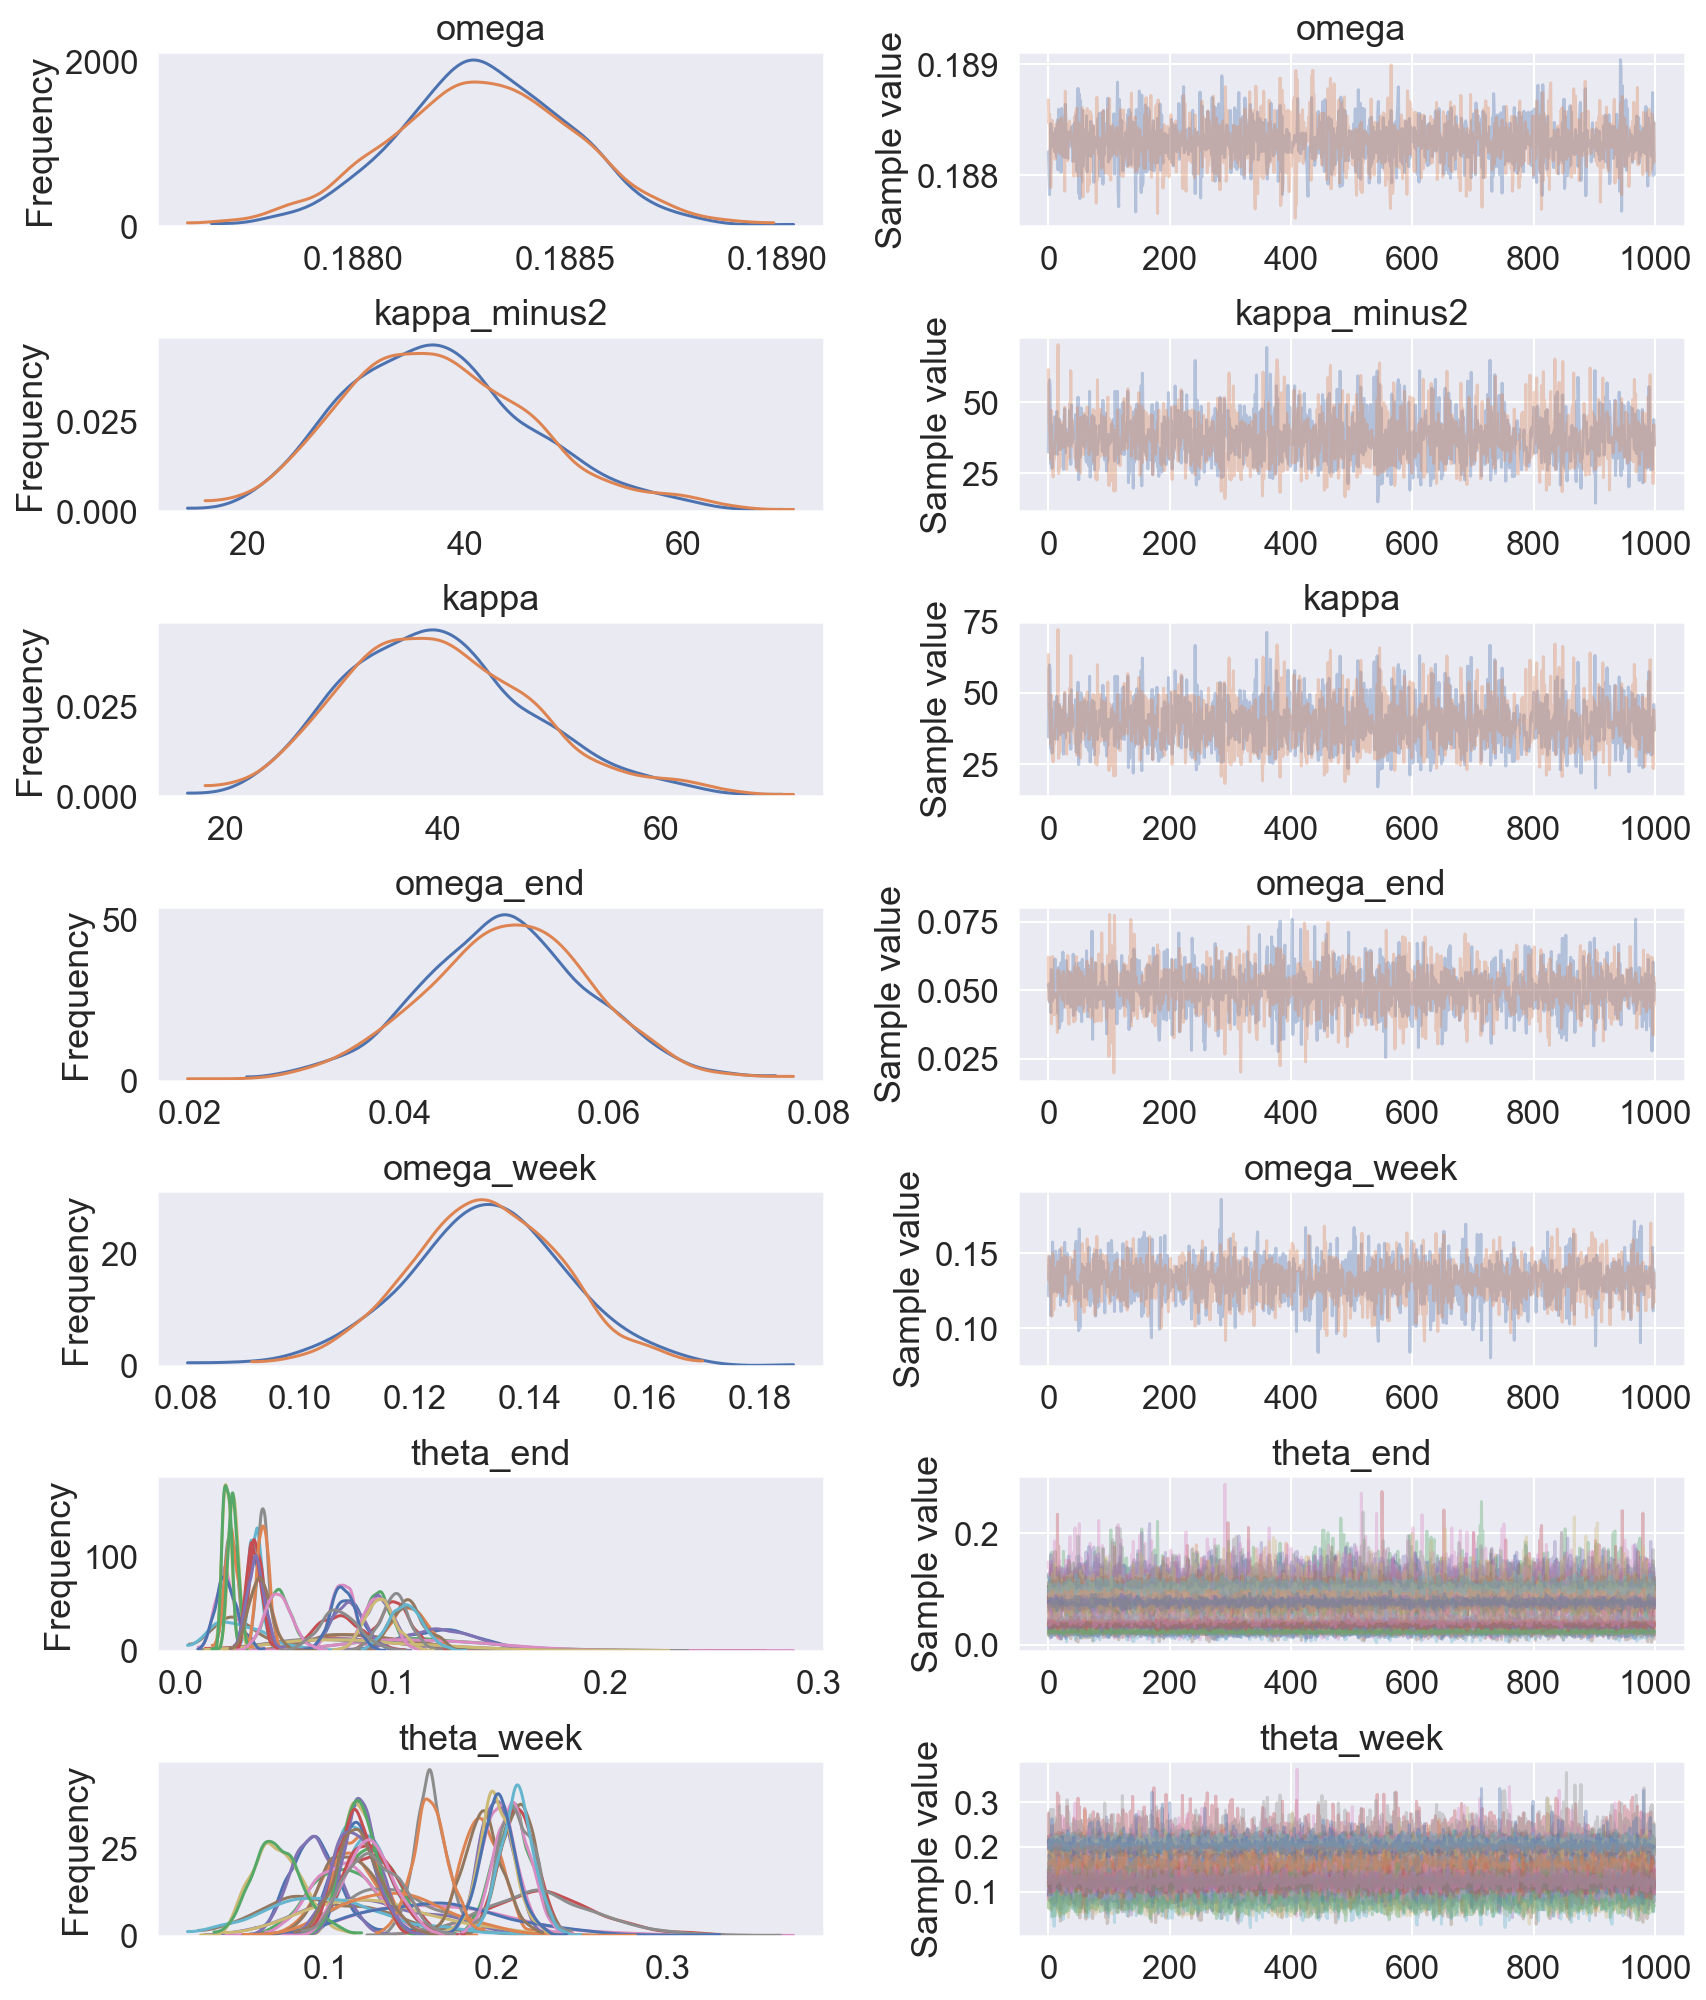

In [55]:
pm.traceplot(trace_w)
plt.show()

## Resources

<a name='Kruschke'></a> J. K. Kruschke: Doing Bayesian Data Analysis (2nd edition), Academic Press, 2015, chapter 9